In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("/Users/devanshjavia/Desktop/Proj/EDA on Retail Sales Data/menu.csv")
print("Shape:", df.shape)
df.head()


Shape: (260, 24)


,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


In [3]:
df.info()
df.describe(include='all')
df['Category'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

Category
Coffee & Tea          95
Breakfast             42
Smoothies & Shakes    28
Chicken & Fish        27
Beverages             27
Beef & Pork           15
Snacks & Sides        13
Desserts               7
Salads                 6
Name: count, dtype: int64

In [4]:
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])

# Strategy: Drop rows with critical NA, fill others
df.dropna(subset=['Calories'], inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)


Missing Values:
 Series([], dtype: int64)


In [5]:
import scipy.stats as stats

# Z-score method
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]
print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (226, 24)


In [6]:
# Remove non-digit characters and convert to float
df['Serving Size (Numeric)'] = df['Serving Size'].str.extract('(\d+\.?\d*)')[0].astype(float)

# Calculate Calorie Density
df['Calorie Density'] = df['Calories'] / df['Serving Size (Numeric)']


# Add Macronutrient Ratio
df['Fat to Carb Ratio'] = df['Total Fat'] / (df['Carbohydrates'] + 1)



# Category Encoding
df['Category_Encoded'] = pd.factorize(df['Category'])[0]


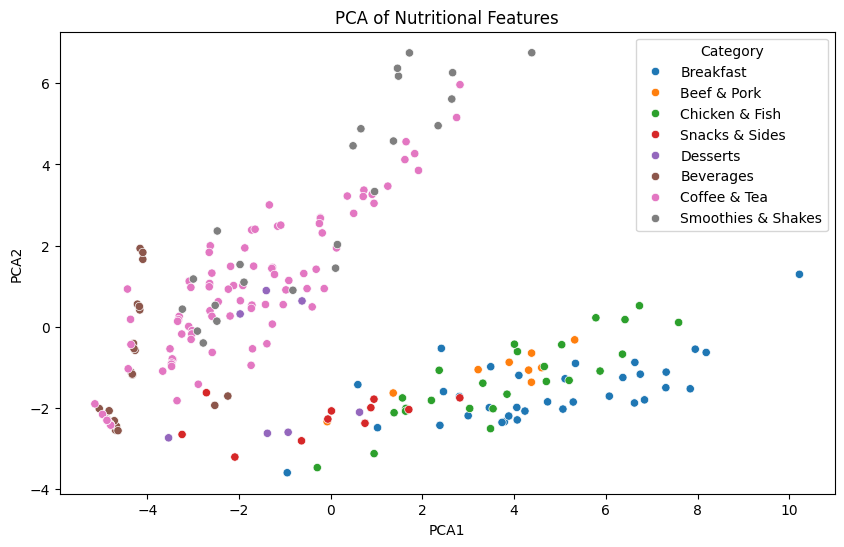

In [7]:
numeric = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled = scaler.fit_transform(numeric)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Category', data=df)
plt.title("PCA of Nutritional Features")
plt.show()


In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

px.scatter(df, x='PCA1', y='PCA2', color='Cluster', title='Food Clusters')


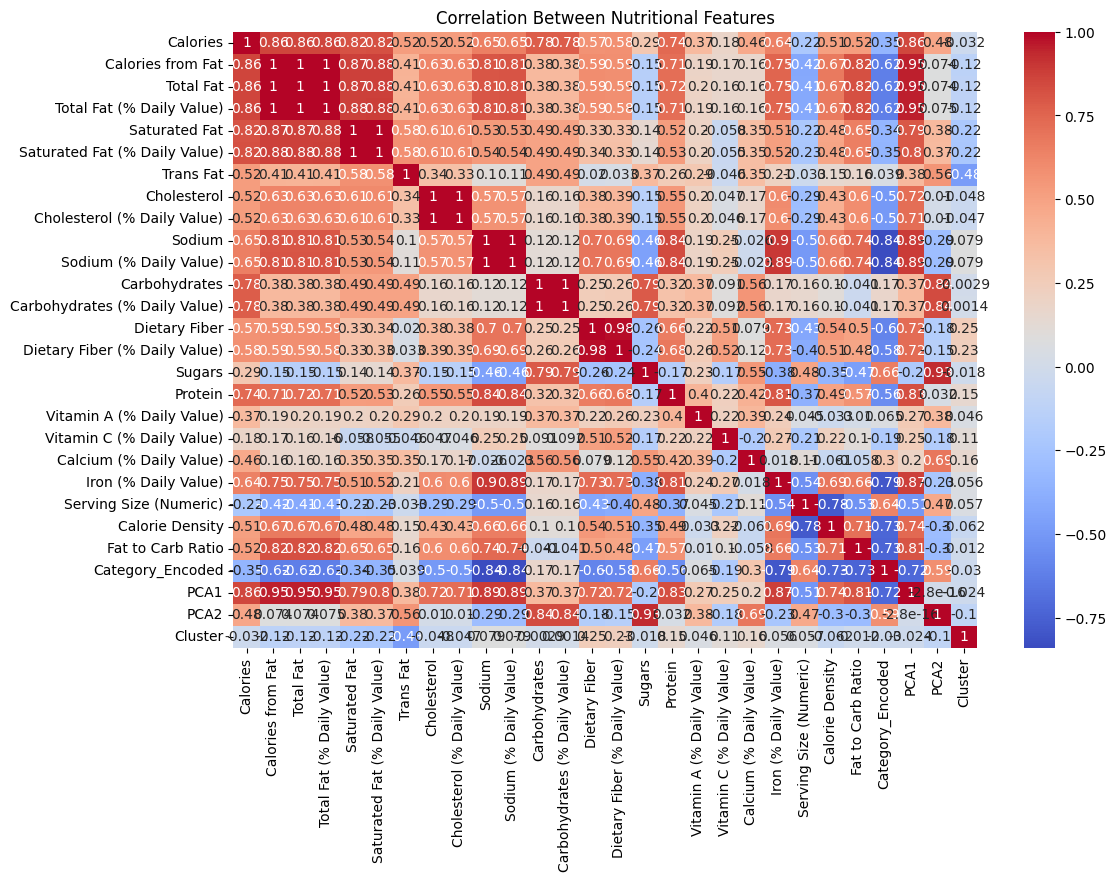

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Between Nutritional Features")
plt.show()


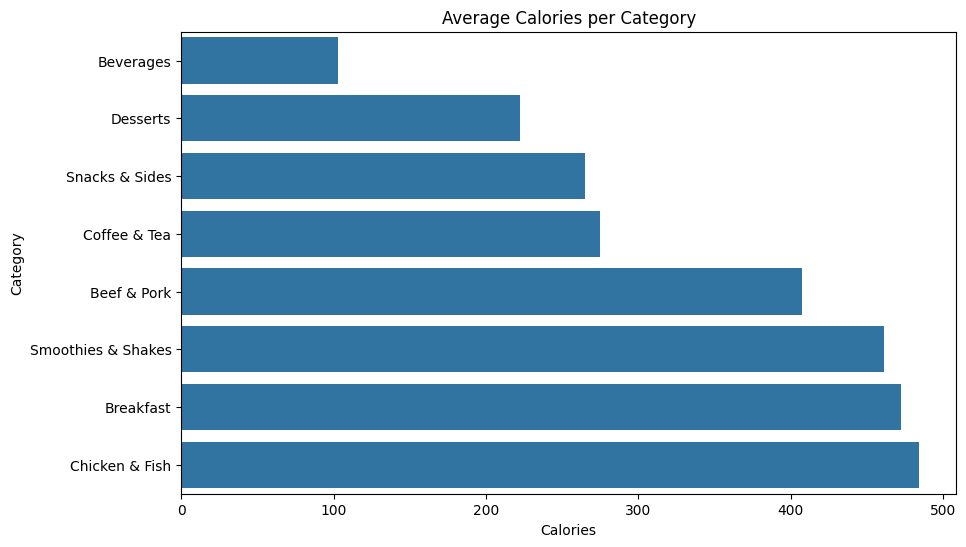

In [10]:
category_group = df.groupby('Category')['Calories'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(y=category_group.index, x=category_group.values)
plt.title("Average Calories per Category")
plt.xlabel("Calories")
plt.ylabel("Category")
plt.show()


In [12]:
features = ['Total Fat', 'Sodium', 'Carbohydrates', 'Protein']
X = df[features]
y = df['Calories']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.9658490750252056
RMSE: 25.74423424497034


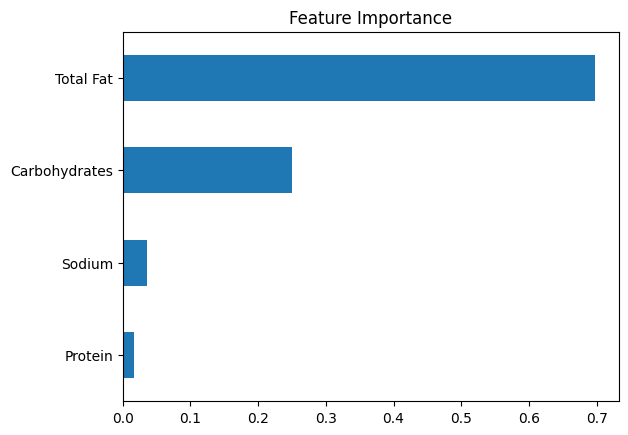

In [13]:
feat_imp = pd.Series(model.feature_importances_, index=features)
feat_imp.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()


In [15]:
import plotly.express as px

fig = px.scatter(
    df,
    x='Calories',
    y='Total Fat',
    color='Category',
    size='Protein',
    hover_data=['Serving Size'],
    title="Calories vs Fat colored by Category"
)
fig.show()


In [22]:
df.to_csv("processed_nutrition_facts.csv", index=False)
